# Projeto: Otimização de Portfólio 
Contexto:<br>
Desenvolveremos a otimização de três (03) portfólios composto por 03 empresas (que no incio do 2023 foram sugeridos por reconhecidos Investidores Brasileiros) da bolsa brasileira, aplicando algoritmos de otimização e aprendizagem profunda em cenários de risco não sistemático, analisando os riscos e procurando maximizar os rendimentos do portfólio ao final do período. <br> <br>
Bases: <br> 
No estudo, consideramos dados de movimentações da Bolsa Brasileira, no período desde 2018-01-01 até 2023-06-30. Totalizando cinco (05) anos, mais os restantes seis (06) meses do 2023.<br><br>
Portfólios:<br> Os portfólios estão compostos pelas seguintes empresas:<br>
1. Portfólio_LB. [BB Seguridade, Banco do Brasil, Cosan].
2. Portfólio_TN. [RAPT3, RANI3, LEVE3]
3. Portfólio_BP. [Itausa, Vivo, Sanepa]<br><br>

Algoritmos de Otimização:<br>
No estudo, aplicaremos os seguintes métodos:
1. Aleátorização.
2. Hill Climb.
3. Simulated Anneling

Previsão de Preços:<br>
Neste ponto aplicaremos tanto a simulação de Monte Carlo e Arima para comparação de resultados com o algoritmo de aprendizagem profunda Long Short Term Memory. 

Finalmente, apresentaremos um quandro de resumo contendo os resultados obtidos assim como os gráficos dos nossos rendimentos simulados.

## Importação dos Dados

### Bibliotecas

In [3]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import yfinance as yf 
import mlrose_hiive 
import math

In [4]:
def plot_histograms(df):
    num_columns = len(df.columns)
    fig, axs = plt.subplots(num_columns, 1, figsize=(14, 20))
    for i in range(num_columns):
        sns.histplot(df[df.columns[i]], kde=True, ax=axs[i])
        axs[i].set_title(df.columns[i])
            

def plot_boxplots(df):
    num_columns = len(df.columns)
    
    fig, axs = plt.subplots(num_columns, 1, figsize=(14, 20))
    
    for i in range(num_columns):
        sns.boxplot(x=df[df.columns[i]], ax=axs[i])
        axs[i].set_title(df.columns[i])

def normalize_columns(df):
    df_normalized = df.copy()
    
    for column in df_normalized.columns:
        df_normalized[column] = df_normalized[column] / df_normalized[column][0]
    
    return df_normalized

def plot_stock_price_history(df_normalized, title='Histórico de preço de Ações'):
    figura = px.line(title=title)
    
    for column in df_normalized.columns:
        figura.add_scatter(x=df_normalized.index, y=df_normalized[column], name=column)
    
    figura.show()


In [5]:
def alocacao_ativos(dataset, dinheiro_total, seed=0, melhores_pesos = []):
    dataset = dataset.copy()
    
    if seed != 0:
        np.random.seed(seed)
    
    if len(melhores_pesos) > 0:
      pesos = melhores_pesos
    else:     
      pesos = np.random.random(len(dataset.columns))
      pesos = pesos / pesos.sum()
      print(pesos, pesos.sum())

    colunas = dataset.columns
    for coluna in colunas:
        dataset[coluna] = (dataset[coluna] / dataset[coluna].iloc[0])

    for i, acao in enumerate(colunas):
        dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    dataset['soma_valor'] = dataset.sum(axis=1)
    # Extrair as datas do índice do DataFrame df_lb
    datas = pd.DataFrame({'Data': df_lb.index})
    dataset['taxa_retorno'] = 0.0
    for i in range(1, len(dataset)):
        dataset.loc[dataset.index[i], 'taxa_retorno'] = ((dataset['soma_valor'].iloc[i] / dataset['soma_valor'].iloc[i - 1]) - 1) * 100
    
    acoes_pesos = pd.DataFrame(data={'Ações': colunas, 'Pesos': pesos * 100})
    
    return dataset,datas, acoes_pesos, dataset.iloc[-1]['soma_valor']

In [6]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0
  
  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns))
    pesos = pesos / pesos.sum()

    for i in dataset.columns:
      dataset[i] = dataset[i] / dataset[i][0]

    colunas = dataset.columns
    for i, acao in enumerate(colunas):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    #for i, acao in enumerate(dataset.columns):
   #   dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    dataset['soma_valor'] = dataset.sum(axis = 1)
    dataset['taxa_retorno'] = 0.0

    for i in range(1, len(dataset)):
      dataset['taxa_retorno'][i] = np.log(dataset['soma_valor'][i] / dataset['soma_valor'][i - 1])

    #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)
    retorno_esperado = np.sum(dataset['taxa_retorno'].mean() * pesos) * 246
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 246, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)
    
    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

### Importando Dados

#### Portfólio Ibovespa

In [7]:
ticker_symbols = ['BOVA11.SA']  
start_date = '2018-01-01'
end_date = '2023-09-30'
df_b3 = yf.download(ticker_symbols, start=start_date, end=end_date)
df_b3.head()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2018-01-02  74.000000  75.230003  74.000000  75.099998  75.099998  2292470
2018-01-03  75.000000  75.769997  74.900002  75.300003  75.300003  3765200
2018-01-04  75.540001  76.440002  75.510002  76.000000  76.000000  2245750
2018-01-05  76.000000  76.440002  75.559998  76.440002  76.440002  2288790
2018-01-08  76.330002  76.760002  75.930000  76.760002  76.760002  2544400

In [8]:
# Mentando apenas a coluna 'Close' e renomeie-a para 'BOVA11'
df_b3 = df_b3[['Close']].rename(columns={'Close': 'BOVA11'})
df_b3.head()

BOVA11
Date                 
2018-01-02  75.099998
2018-01-03  75.300003
2018-01-04  76.000000
2018-01-05  76.440002
2018-01-08  76.760002

In [9]:
df_b3.shape

(1409, 1)

#### Portfólio_LB

In [10]:
# (COSAN S.A; BANCO DO BRASIL, BB SEGURIDADE)
ticker_symbols = ['CSAN3.SA', 'BBAS3.SA', 'BBSE3.SA'] 
df_lb = yf.download(ticker_symbols, start=start_date, end=end_date)
df_lb.head()

[*********************100%%**********************]  3 of 3 completed


Adj Close                           Close                      \
             BBAS3.SA   BBSE3.SA  CSAN3.SA   BBAS3.SA   BBSE3.SA CSAN3.SA   
Date                                                                        
2018-01-02  22.981621  17.394703  8.715409  32.930000  28.700001  10.6375   
2018-01-03  23.274736  17.406824  8.715409  33.349998  28.719999  10.6375   
2018-01-04  23.498058  17.443190  8.694927  33.669998  28.780001  10.6125   
2018-01-05  23.498058  17.558346  8.785051  33.669998  28.969999  10.7225   
2018-01-08  23.553894  17.661383  8.709264  33.750000  29.139999  10.6300   

                 High                            Low                      \
             BBAS3.SA   BBSE3.SA CSAN3.SA   BBAS3.SA   BBSE3.SA CSAN3.SA   
Date                                                                       
2018-01-02  32.930000  28.790001  10.6750  32.090000  28.540001  10.4125   
2018-01-03  33.419998  28.959999  10.8225  32.820000  28.520000  10.5300   
2018-01-04  33.959999  28.980000  10.8250  33.450001  28.700001  10.5775   
2018-01-05  33.900002  29.170000  10.7800  33.290001  28.620001  10.4825   
2018-01-08  33.750000  29.190001  10.7225  33.340000  28.799999  10.4425   

                 Open                       Volume                    
             BBAS3.SA   BBSE3.SA CSAN3.SA BBAS3.SA BBSE3.SA CSAN3.SA  
Date                                                                  
2018-01-02  32.090000  28.650000  10.4750  9178100  1901000  3486800  
2018-01-03  33.099998  28.700001  10.6375  8180700  2100400  6272000  
2018-01-04  33.520000  28.830000  10.6550  9625200  2349500  5763200  
2018-01-05  33.700001  28.809999  10.5275  5267800  2585900  6156400  
2018-01-08  33.639999  29.000000  10.7000  5130600  2629300  3541600

In [11]:
# Selecione apenas as colunas desejadas
df_lb = df_lb[[
    ('Close', 'BBAS3.SA'),
    ('Close', 'BBSE3.SA'),
    ('Close', 'CSAN3.SA')
]]
df_lb.columns = ['BBAS3', 'BBSE3', 'CSAN3'] 
df_lb

BBAS3      BBSE3      CSAN3
Date                                       
2018-01-02  32.930000  28.700001  10.637500
2018-01-03  33.349998  28.719999  10.637500
2018-01-04  33.669998  28.780001  10.612500
2018-01-05  33.669998  28.969999  10.722500
2018-01-08  33.750000  29.139999  10.630000
...               ...        ...        ...
2023-09-25  46.419998  32.029999  17.740000
2023-09-26  45.759998  31.830000  17.280001
2023-09-27  46.160000  31.469999  16.840000
2023-09-28  47.639999  31.700001  16.889999
2023-09-29  47.180000  31.209999  17.139999

[1427 rows x 3 columns]

#### Portfólio_TN

In [12]:
# (RANDON PART, IRANI , METAL LEVE)
ticker_symbols = ['RAPT3.SA', 'RANI3.SA', 'LEVE3.SA'] 
df_tn = yf.download(ticker_symbols, start=start_date, end=end_date)
df_tn.head()

[*********************100%%**********************]  3 of 3 completed


Adj Close                          Close                    \
             LEVE3.SA  RANI3.SA  RAPT3.SA   LEVE3.SA RANI3.SA RAPT3.SA   
Date                                                                     
2018-01-02  15.530856  1.521546  4.258497  23.940001     1.96     5.55   
2018-01-03  15.582759  1.521546  4.296861  24.020000     1.96     5.60   
2018-01-04  16.258059  1.521546  4.335226  24.940001     1.96     5.65   
2018-01-05  16.264580  1.513783  4.327554  24.950001     1.95     5.64   
2018-01-08  16.231983  1.513783  4.166420  24.900000     1.95     5.43   

                 High                          Low                       Open  \
             LEVE3.SA RANI3.SA RAPT3.SA   LEVE3.SA RANI3.SA RAPT3.SA LEVE3.SA   
Date                                                                            
2018-01-02  24.190001     1.98     5.55  23.830000     1.96     5.30    24.02   
2018-01-03  24.480000     1.97     5.65  23.760000     1.96     5.53    23.76   
2018-01-04  25.320000     1.96     5.65  23.820000     1.96     5.57    24.02   
2018-01-05  25.280001     1.99     5.67  24.650000     1.95     5.44    24.90   
2018-01-08  25.070000     1.95     5.85  24.610001     1.95     5.42    24.85   

                               Volume                    
           RANI3.SA RAPT3.SA LEVE3.SA RANI3.SA RAPT3.SA  
Date                                                     
2018-01-02     1.98     5.30   286800     4700     8600  
2018-01-03     1.97     5.55   270600    12400    11900  
2018-01-04     1.96     5.60   597000        0     7400  
2018-01-05     1.99     5.67   344200     3300    24700  
2018-01-08     1.95     5.71   177800        0    20200

In [13]:
# Selecione apenas as colunas desejadas
df_tn = df_tn[[
    ('Close', 'LEVE3.SA'),
    ('Close', 'RANI3.SA'),
    ('Close', 'RAPT3.SA')
]]
df_tn.columns = ['RAPT3', 'RANI3', 'LEVE3'] 
df_tn

RAPT3  RANI3  LEVE3
Date                               
2018-01-02  23.940001   1.96   5.55
2018-01-03  24.020000   1.96   5.60
2018-01-04  24.940001   1.96   5.65
2018-01-05  24.950001   1.95   5.64
2018-01-08  24.900000   1.95   5.43
...               ...    ...    ...
2023-09-25  49.389999  12.70   9.30
2023-09-26  47.919998  12.37   9.25
2023-09-27  47.950001  12.34   9.24
2023-09-28  48.650002  12.71   9.28
2023-09-29  48.250000  12.67   9.32

[1427 rows x 3 columns]

#### Portfólio_BP

In [14]:
# (ITAUSA, TELEF BRASIL (VIVO) , SANEPAR)
ticker_symbols = ['ITSA3.SA', 'VIVT3.SA', 'SAPR11.SA'] 
df_bp = yf.download(ticker_symbols, start=start_date, end=end_date)
df_bp.head()

[*********************100%%**********************]  3 of 3 completed


Adj Close                           Close                        \
            ITSA3.SA  SAPR11.SA   VIVT3.SA  ITSA3.SA  SAPR11.SA   VIVT3.SA   
Date                                                                         
2018-01-02  6.146908  14.130239  26.836222  8.516918  19.663334  41.400002   
2018-01-03  6.124432  14.008076  26.058365  8.485777  19.493334  40.200001   
2018-01-04  6.264902  13.895495  26.343578  8.680405  19.336666  40.639999   
2018-01-05  6.264902  14.000893  26.408398  8.680405  19.483334  40.740002   
2018-01-08  6.332326  13.917052  26.687132  8.773827  19.366667  41.169998   

                High                             Low                        \
            ITSA3.SA  SAPR11.SA   VIVT3.SA  ITSA3.SA  SAPR11.SA   VIVT3.SA   
Date                                                                         
2018-01-02  8.548058  19.766666  41.549999  8.213298  19.486666  40.910000   
2018-01-03  8.641480  19.733334  41.439999  8.376786  19.360001  40.200001   
2018-01-04  8.734901  19.600000  40.900002  8.485777  19.216665  40.130001   
2018-01-05  8.750471  19.666666  40.889999  8.594769  19.083332  40.400002   
2018-01-08  8.773827  19.510000  41.200001  8.586984  19.340000  40.250000   

                Open                         Volume                      
            ITSA3.SA  SAPR11.SA   VIVT3.SA ITSA3.SA  SAPR11.SA VIVT3.SA  
Date                                                                     
2018-01-02  8.267794  19.600000  41.549999   161590  2235300.0     6400  
2018-01-03  8.477992  19.686666  41.439999   141809  1068000.0    29900  
2018-01-04  8.501347  19.503332  40.310001   166599   824100.0    21000  
2018-01-05  8.680405  19.340000  40.400002   150158  1113900.0     4400  
2018-01-08  8.618124  19.500000  40.250000   149130   538200.0     6800

In [15]:
# Selecione apenas as colunas desejadas
df_bp = df_bp[[
    ('Close', 'ITSA3.SA'),
    ('Close', 'SAPR11.SA'),
    ('Close', 'VIVT3.SA')
]]
df_bp.columns = ['ITSA3', 'VIVT3', 'SAPR11'] 
df_bp 

ITSA3      VIVT3     SAPR11
Date                                      
2018-01-02  8.516918  19.663334  41.400002
2018-01-03  8.485777  19.493334  40.200001
2018-01-04  8.680405  19.336666  40.639999
2018-01-05  8.680405  19.483334  40.740002
2018-01-08  8.773827  19.366667  41.169998
...              ...        ...        ...
2023-09-25  9.170000  23.190001  44.000000
2023-09-26  9.030000  22.780001  43.910000
2023-09-27  9.040000  22.580000  43.200001
2023-09-28  9.070000  22.530001  43.330002
2023-09-29  9.150000  22.860001  43.180000

[1427 rows x 3 columns]

### Distribuição dos dados

#### Portfólio_LB

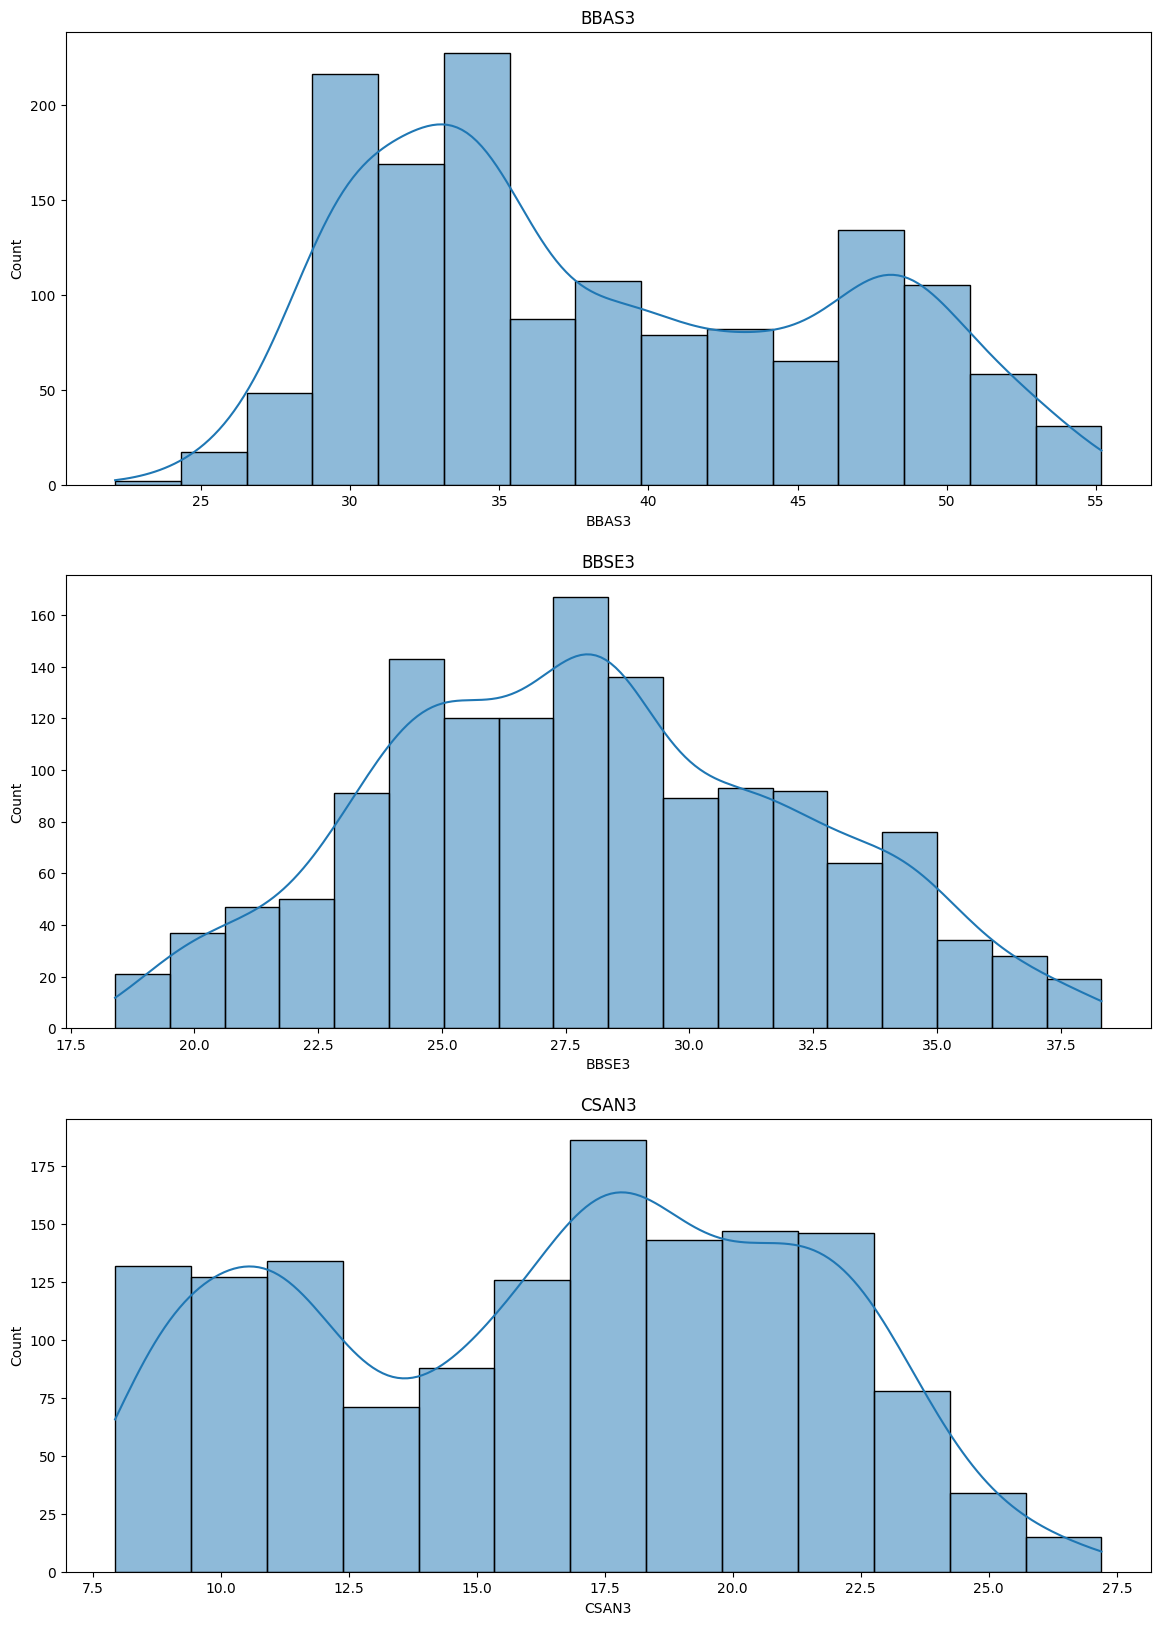

In [16]:
plot_histograms(df_lb)

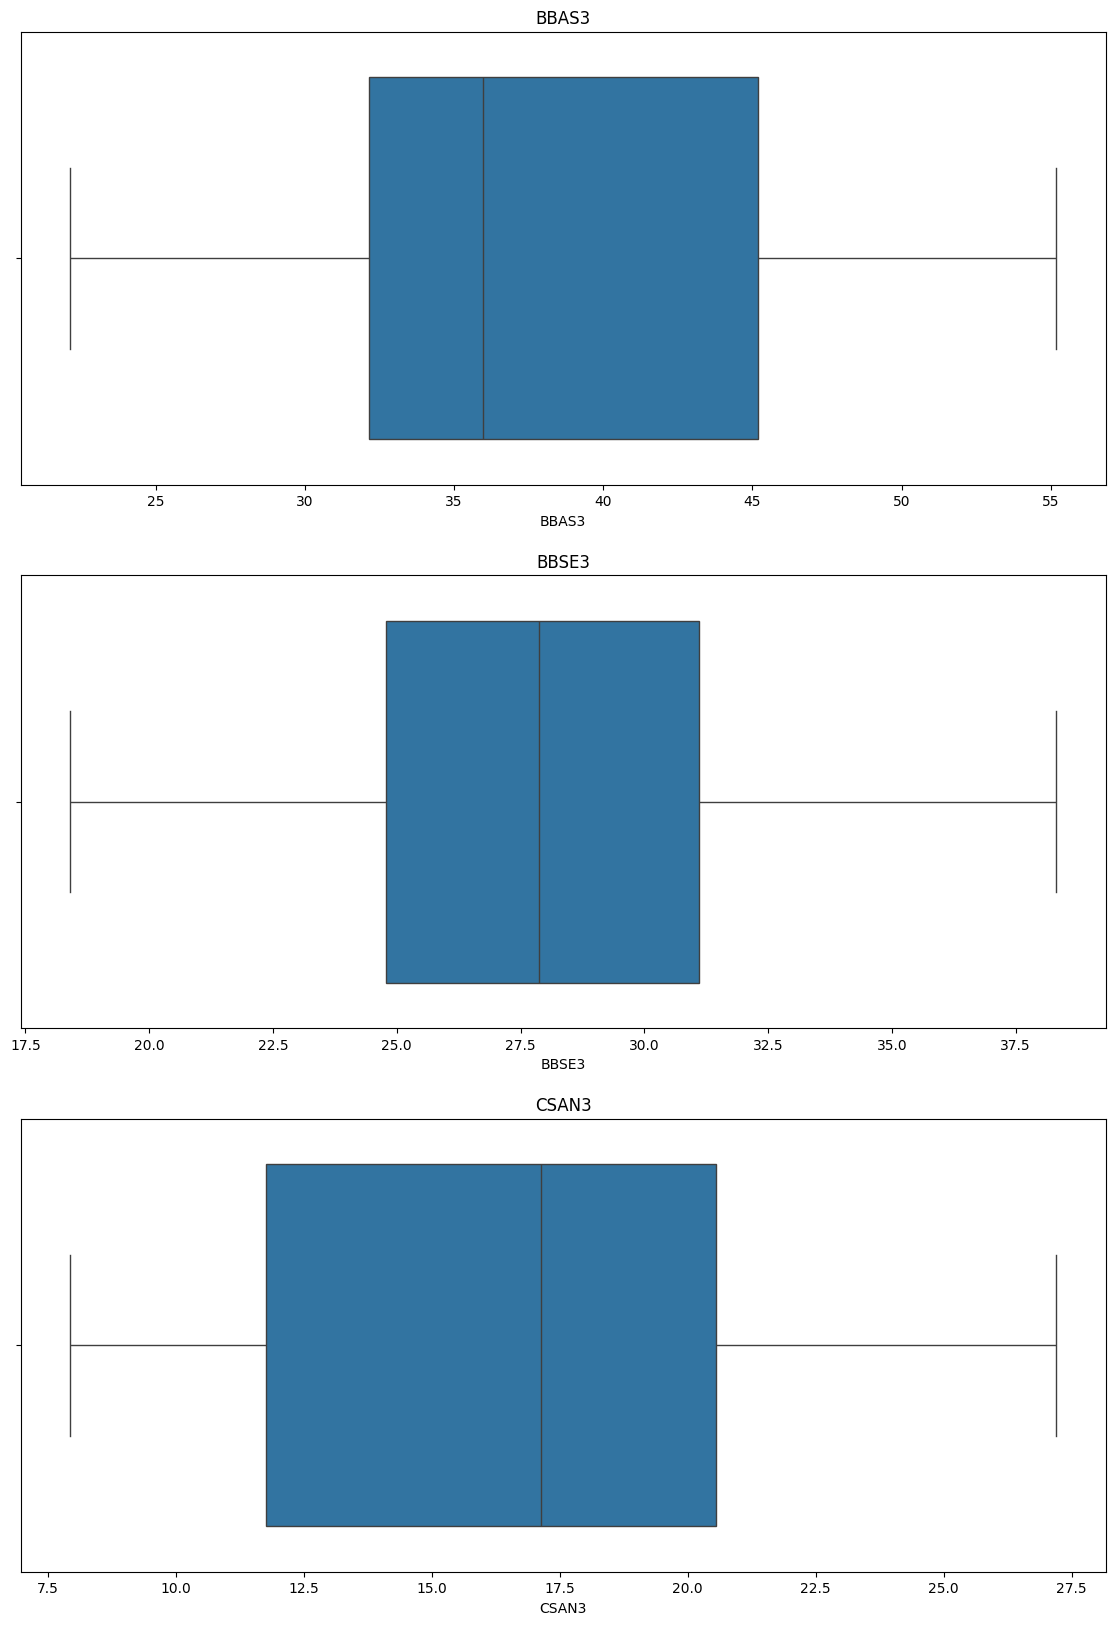

In [17]:
plot_boxplots(df_lb)

#### Portfólio_TN

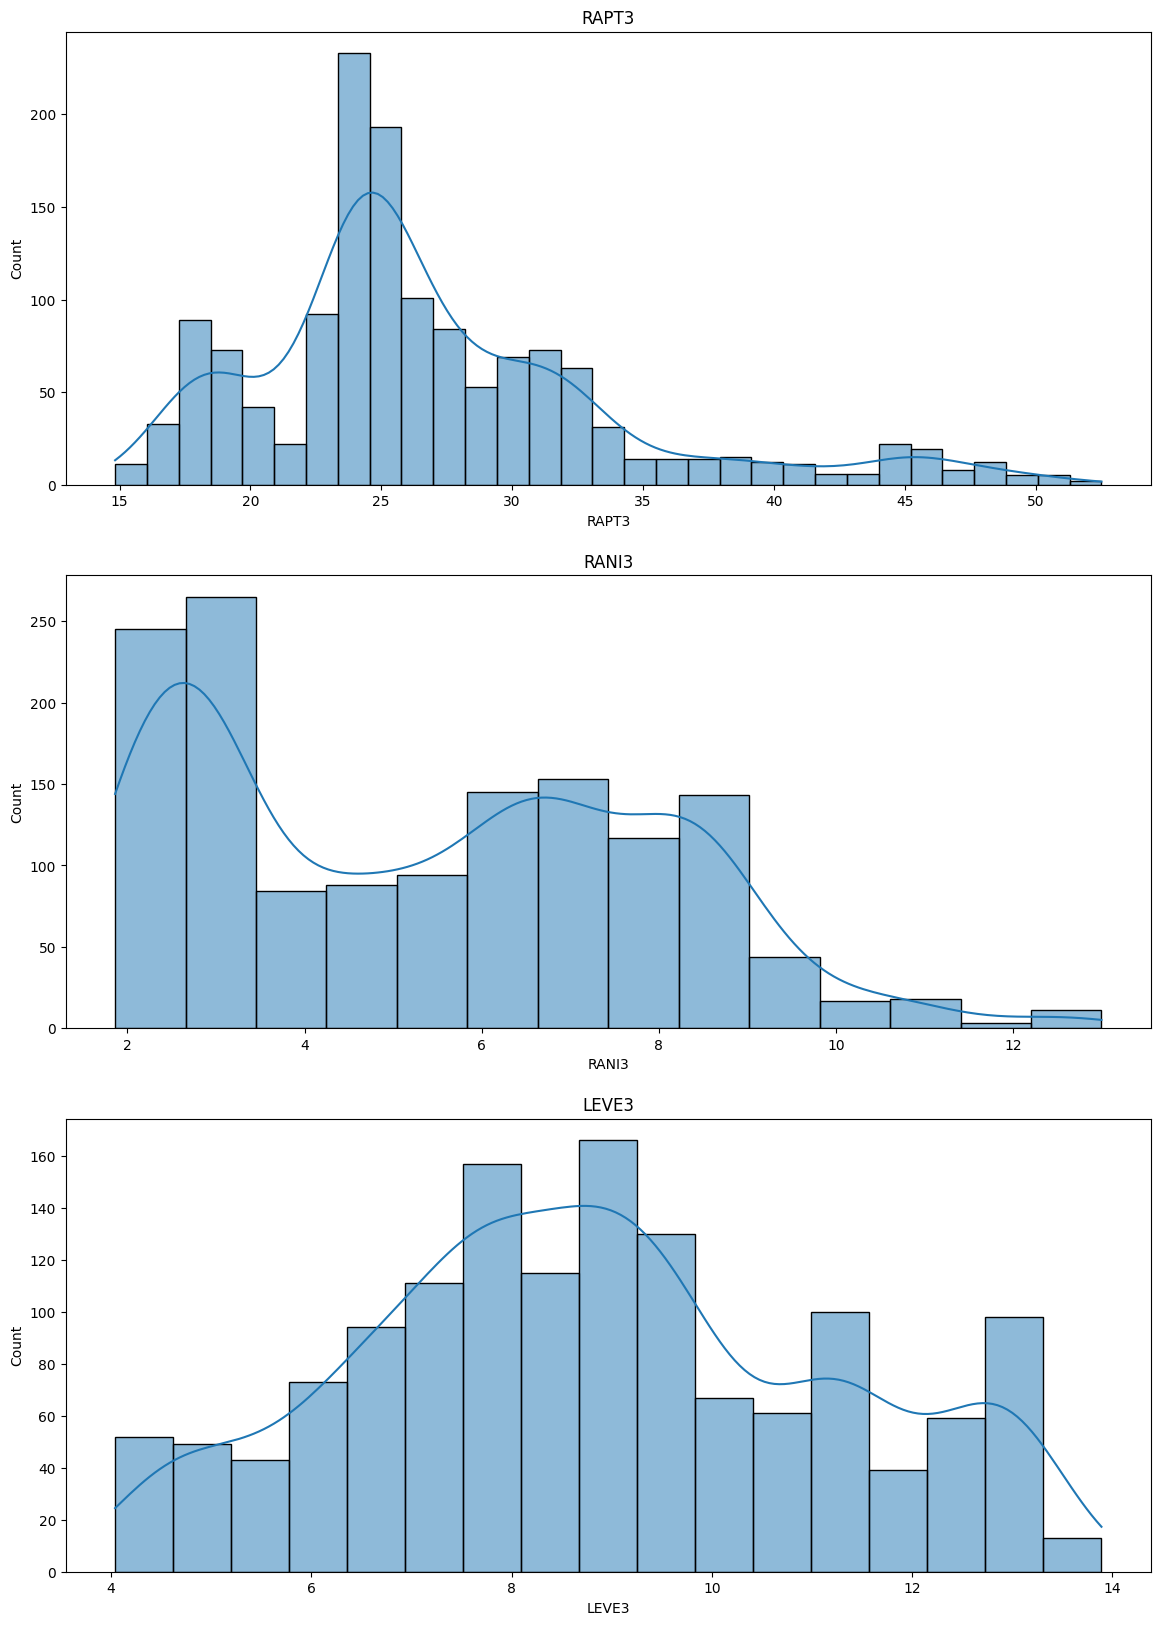

In [18]:
plot_histograms(df_tn)

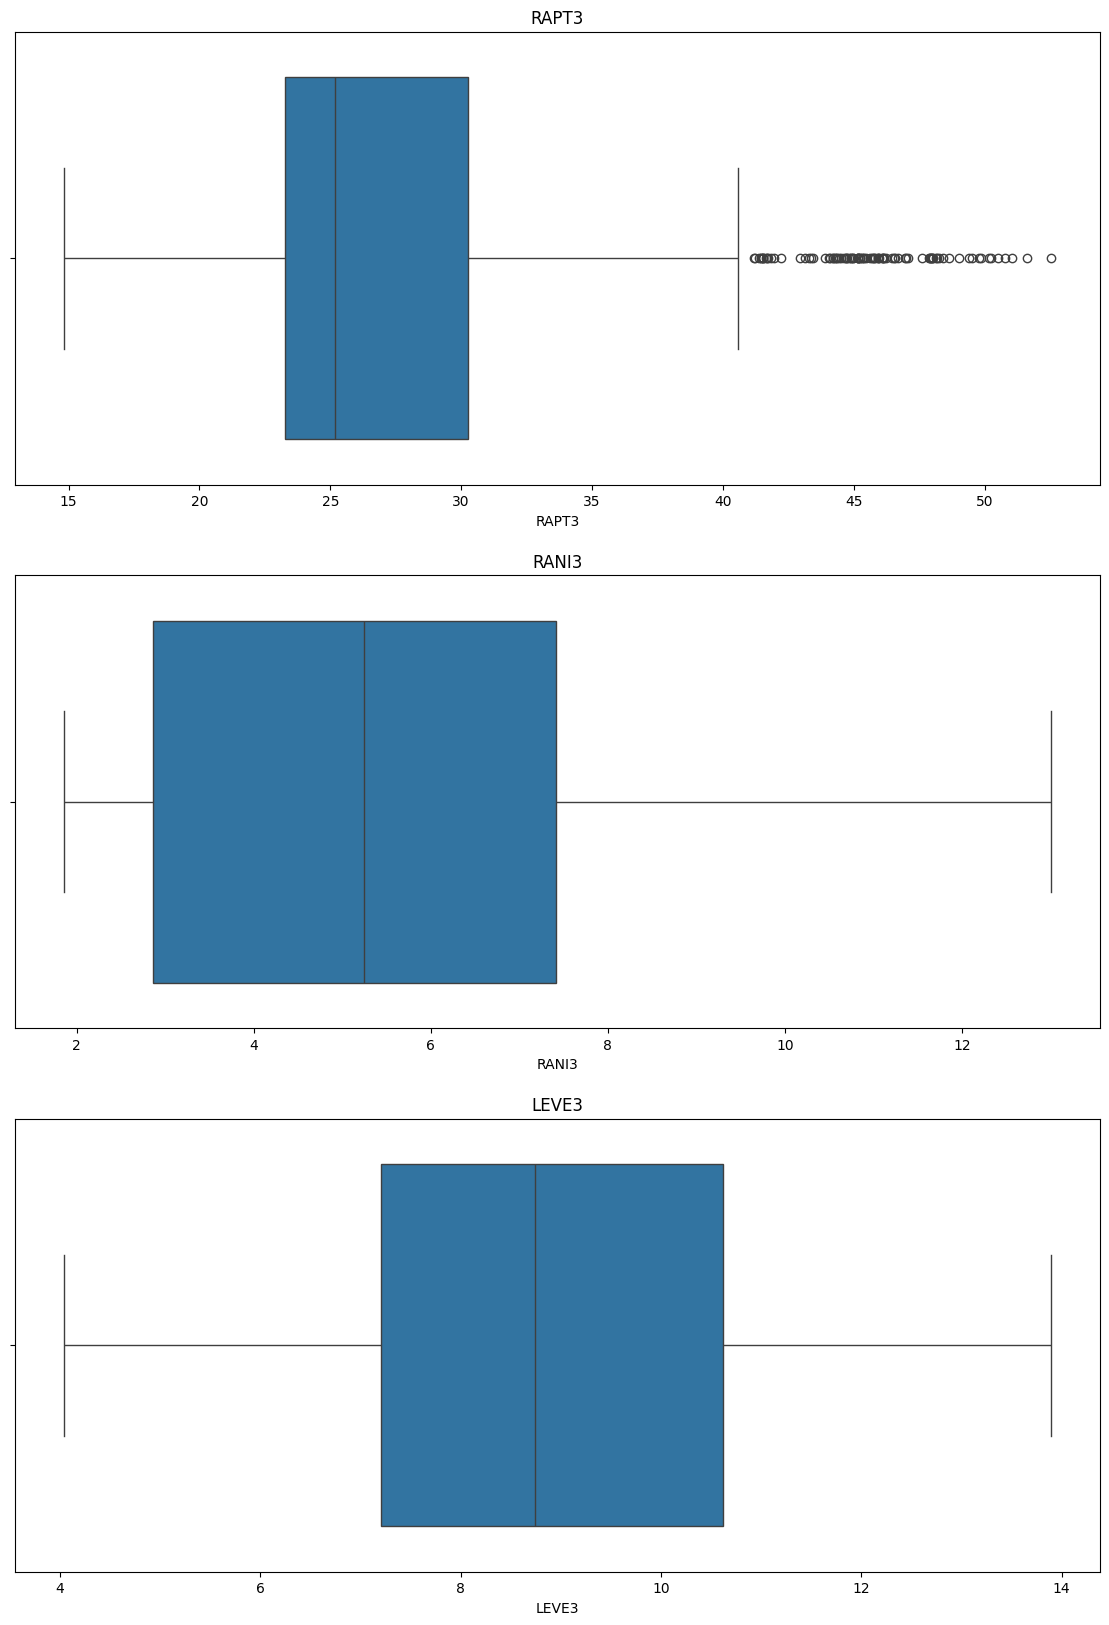

In [19]:
plot_boxplots(df_tn)

#### Portfólio_BP

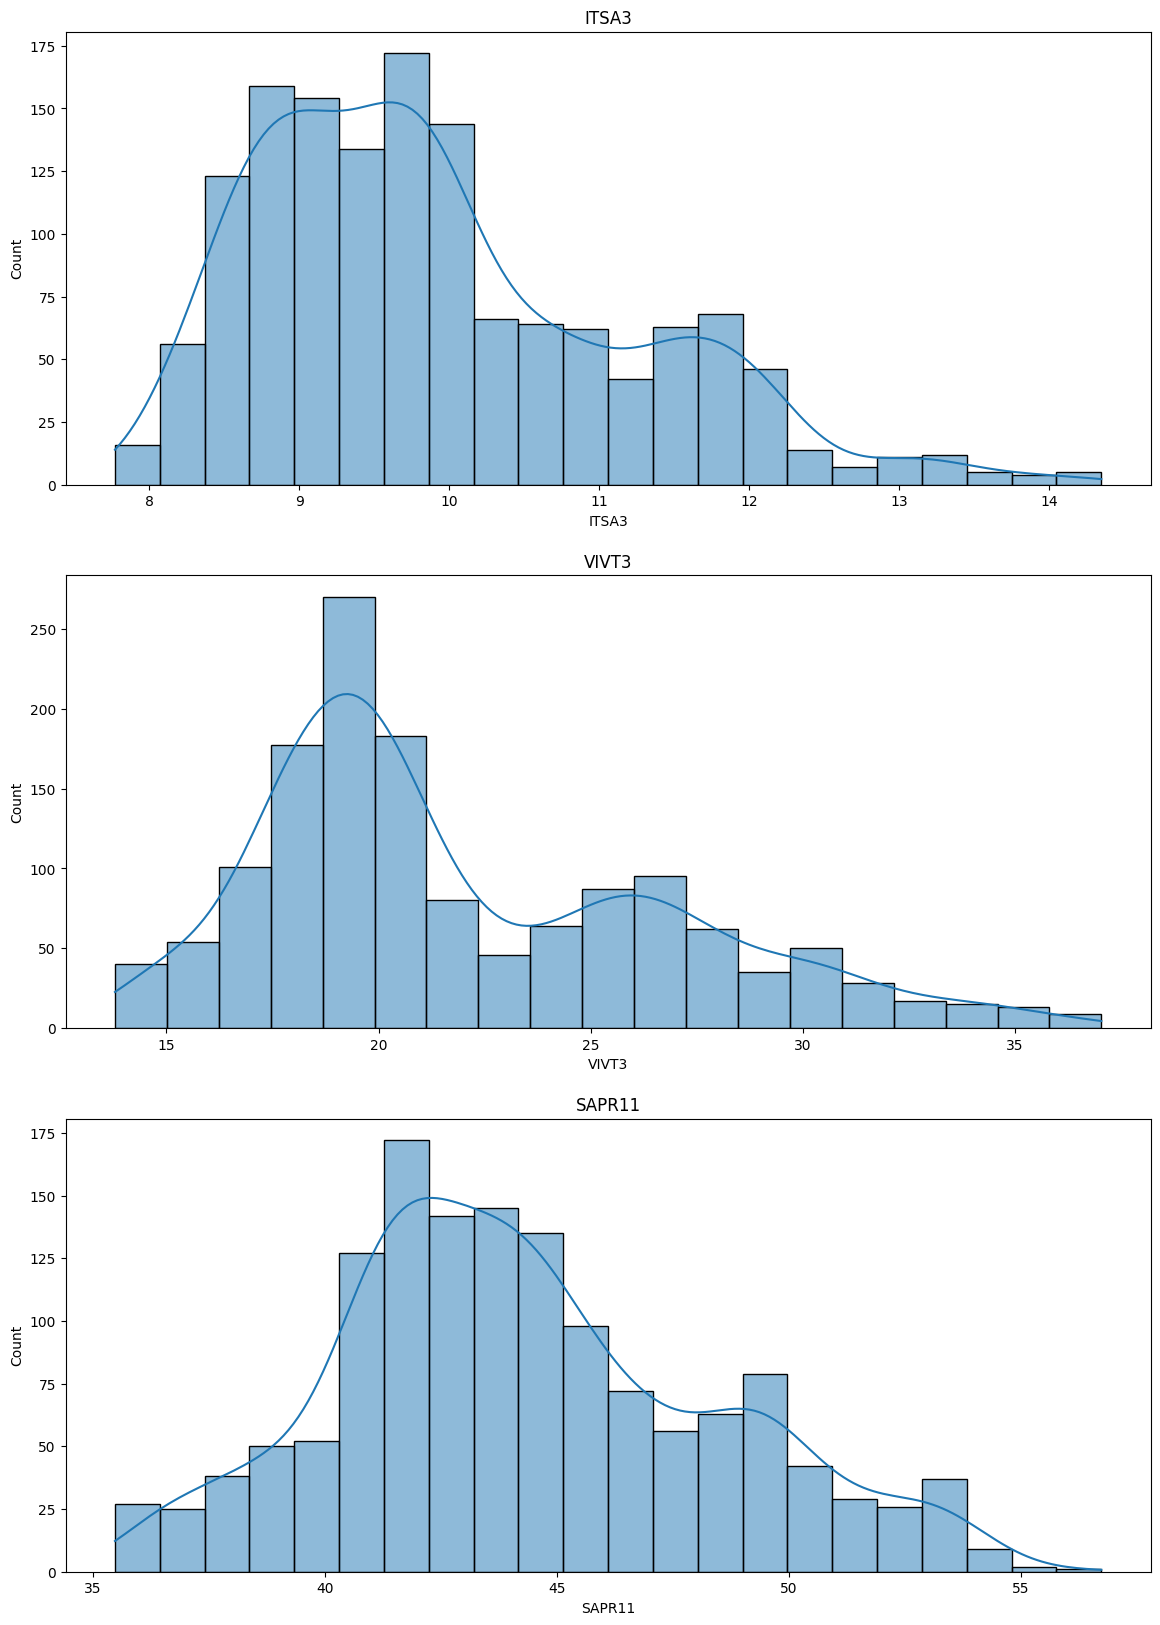

In [20]:
plot_histograms(df_bp)

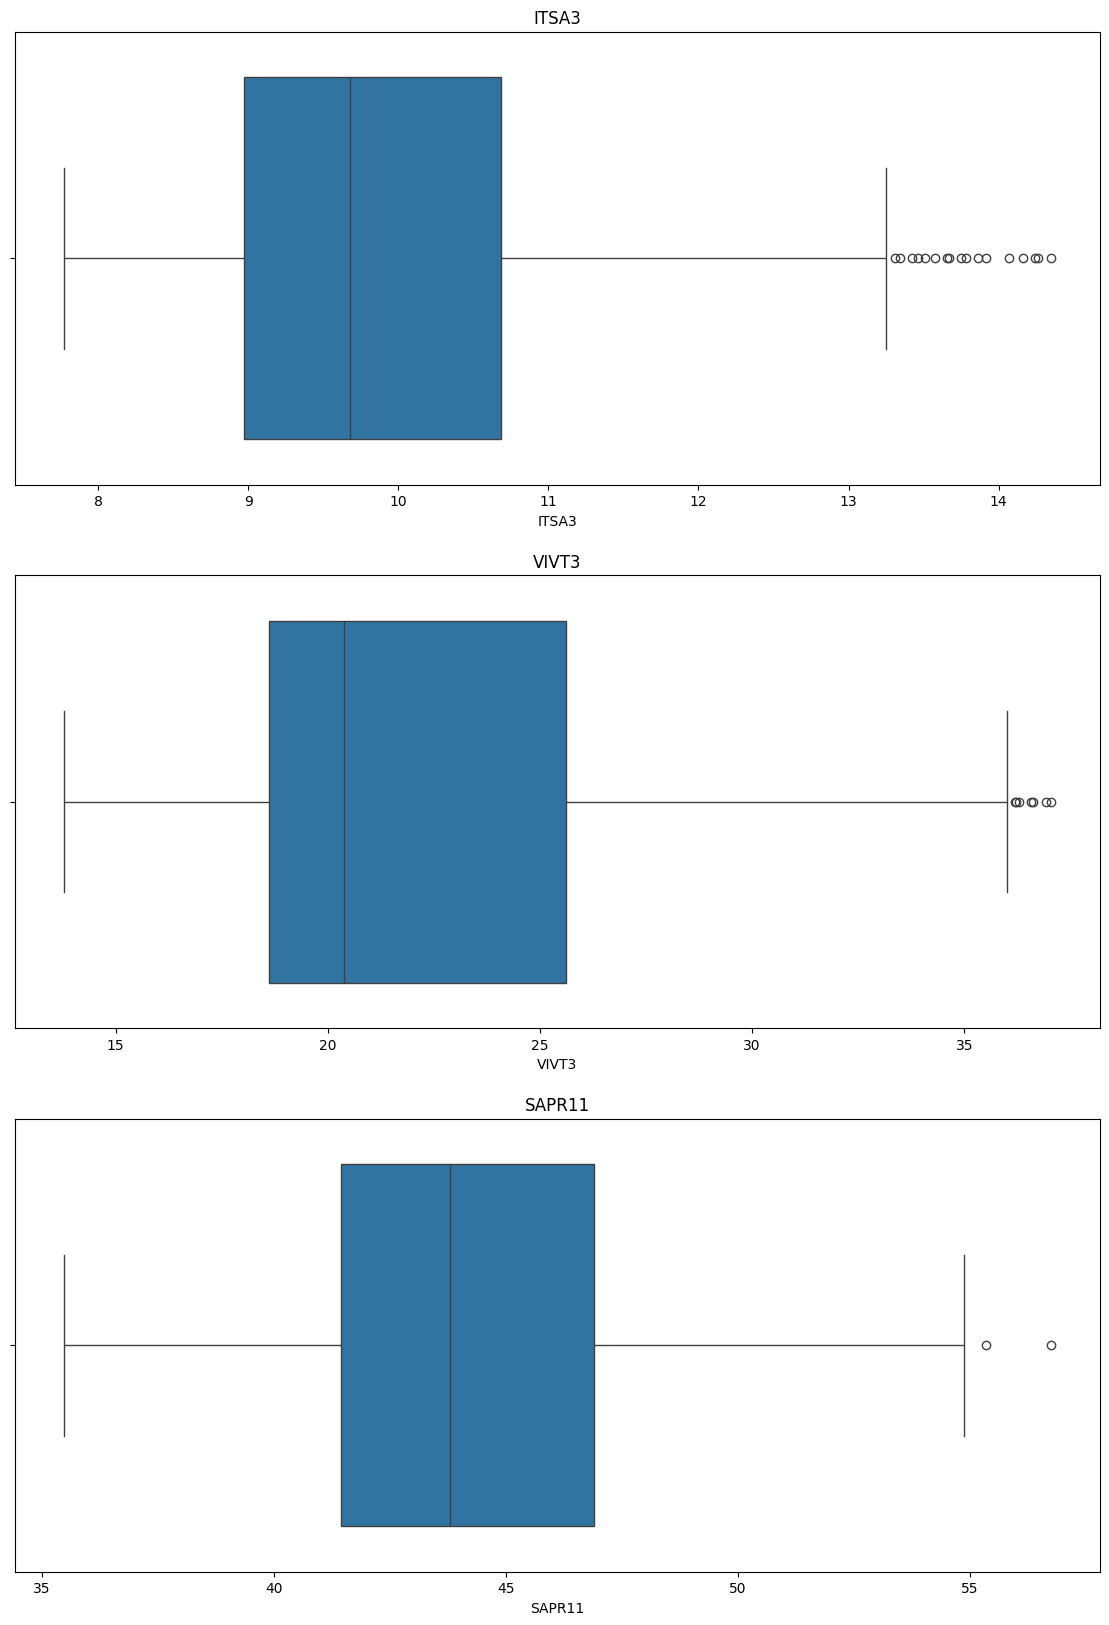

In [21]:
plot_boxplots(df_bp)

### Gráficos dos Portfólios - Diferentes escalas 

#### Portfólio_LB

<Axes: title={'center': 'Histórico do preço de Ações - Portfólio_LN'}, xlabel='Date'>

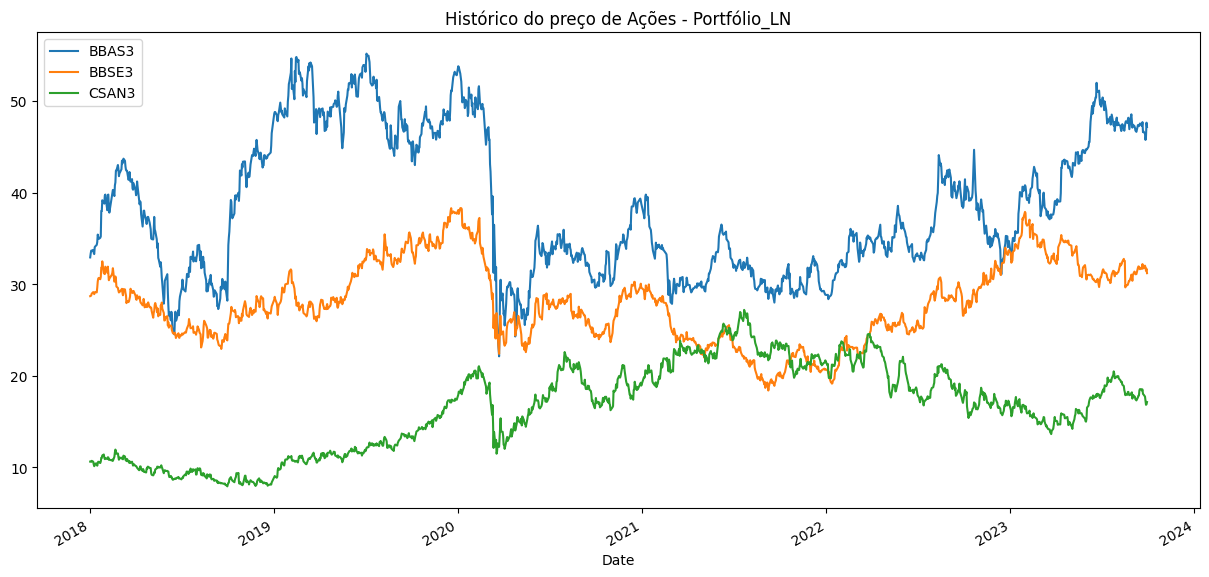

In [22]:
df_lb.plot(figsize=(15,7), title='Histórico do preço de Ações - Portfólio_LN')

#### Portfólio_TN

<Axes: title={'center': 'Histórico do preço de Ações - Portfólio_TN'}, xlabel='Date'>

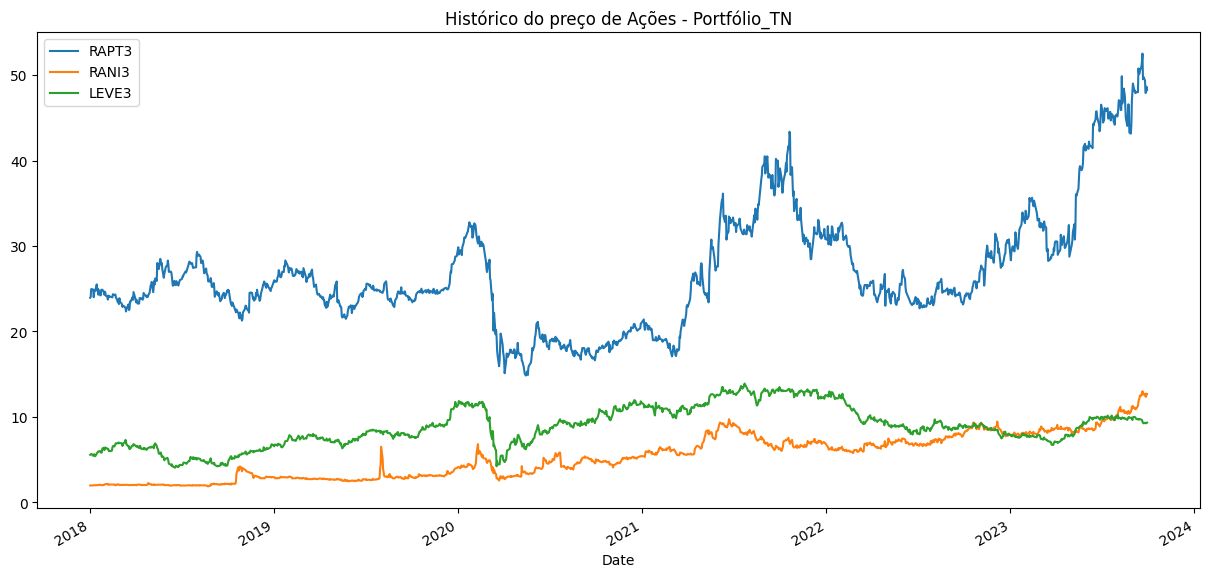

In [23]:
df_tn.plot(figsize=(15,7), title='Histórico do preço de Ações - Portfólio_TN')

#### Portfólio_BP

<Axes: title={'center': 'Histórico do preço de Ações - Portfólio_BP'}, xlabel='Date'>

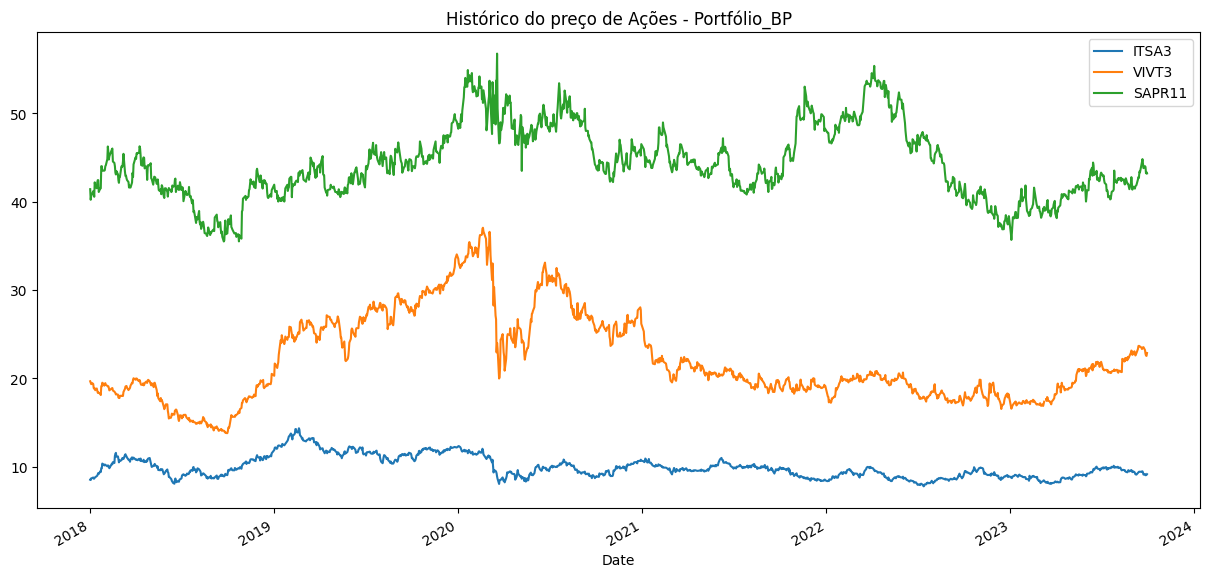

In [24]:
df_bp.plot(figsize=(15,7), title='Histórico do preço de Ações - Portfólio_BP')

### Gráficos dos Portfólios - Ações Normalizadas

#### Portfólios_LB

In [25]:
df_lb_normalizado = normalize_columns(df_lb)

In [26]:
plot_stock_price_history(df_lb_normalizado, title='Histórico de preço de Ações - Portfólio_LB')

#### Portfólios_TN

In [27]:
df_tn_normalizado = normalize_columns(df_tn)

In [28]:
plot_stock_price_history(df_tn_normalizado, title='Histórico de preço de Ações - Portfólio_TN')

#### Portfólios_BP

In [29]:
df_bp_normalizado = normalize_columns(df_bp)

In [30]:
plot_stock_price_history(df_bp_normalizado, title='Histórico de preço de Ações - Portfólio_BP')

## Taxas de Retorno dos Portfólios

In [31]:
'''
Definirei os pesos para as carteiras de manera igualmente distribuido, 
a principio para simple comparação
'''
pesos_carteira = np.array([0.36, 0.32,0.32])

#### Portfólio_LB

In [32]:
'''
taxa de retorno simples pq estamos fazendo comparativo em um mesmo 
periodo de tempo para várias empresas
'''
retorno_carteira_lb = (df_lb_normalizado / df_lb_normalizado.shift(1)) -1 
retorno_carteira_lb.head()

BBAS3     BBSE3     CSAN3
Date                                    
2018-01-02       NaN       NaN       NaN
2018-01-03  0.012754  0.000697  0.000000
2018-01-04  0.009595  0.002089 -0.002350
2018-01-05  0.000000  0.006602  0.010365
2018-01-08  0.002376  0.005868 -0.008627

In [33]:
retorno_anual_lb = retorno_carteira_lb.mean( ) * 246 
retorno_anual_lb

BBAS3    0.138942
BBSE3    0.054998
CSAN3    0.156581
dtype: float64

In [34]:
retorno_anual_lb = retorno_anual_lb * 100
retorno_anual_lb

BBAS3    13.894249
BBSE3     5.499751
CSAN3    15.658125
dtype: float64

In [35]:
np.dot(retorno_anual_lb, pesos_carteira) 

11.772449749182998

Taxa de retorno anual do Portfólio_LB no periodo é de 11.77%

#### Portfólio_TN

In [36]:
retorno_carteira_tn = (df_tn_normalizado / df_tn_normalizado.shift(1)) -1 
retorno_carteira_tn.head()

RAPT3     RANI3     LEVE3
Date                                    
2018-01-02       NaN       NaN       NaN
2018-01-03  0.003342  0.000000  0.009009
2018-01-04  0.038301  0.000000  0.008929
2018-01-05  0.000401 -0.005102 -0.001770
2018-01-08 -0.002004  0.000000 -0.037234

In [37]:
retorno_anual_tn = retorno_carteira_tn.mean( ) * 246 
retorno_anual_tn

RAPT3    0.198580
RANI3    0.502852
LEVE3    0.178400
dtype: float64

In [38]:
retorno_anual_tn = retorno_anual_tn * 100
retorno_anual_tn

RAPT3    19.858033
RANI3    50.285210
LEVE3    17.840033
dtype: float64

In [39]:
np.dot(retorno_anual_tn, pesos_carteira) 

28.948969908474844

Taxa de retorno anual do Portfólio_LB no periodo é de 28.94%

#### Portfólio_BP

In [40]:
retorno_carteira_bp = (df_bp_normalizado / df_bp_normalizado.shift(1)) -1 
retorno_carteira_bp.head()

ITSA3     VIVT3    SAPR11
Date                                    
2018-01-02       NaN       NaN       NaN
2018-01-03 -0.003656 -0.008646 -0.028986
2018-01-04  0.022936 -0.008037  0.010945
2018-01-05  0.000000  0.007585  0.002461
2018-01-08  0.010762 -0.005988  0.010555

In [41]:
retorno_anual_bp = retorno_carteira_bp.mean( ) * 246 
retorno_anual_bp

ITSA3     0.045906
VIVT3     0.072655
SAPR11    0.044133
dtype: float64

In [42]:
retorno_anual_bp = retorno_anual_bp * 100
retorno_anual_bp

ITSA3     4.590629
VIVT3     7.265539
SAPR11    4.413319
dtype: float64

In [43]:
np.dot(retorno_anual_bp, pesos_carteira) 

5.3898609491547065

Taxa de retorno anual do Portfólio_LB no periodo é de 5.38%

#### Conclusão de Taxas de Retorno dos Portfolios

A taxa de retorno mais promissora, com esses pesos distribuidos, seria o Portfolio_TN com taxa de retorno anual de 28.94

### Gráfico dos Portfólios

In [44]:
df_lb_normalizado['carteira_lb'] = (df_lb_normalizado['BBAS3'] + df_lb_normalizado['BBSE3'] + df_lb_normalizado['CSAN3'] ) / 3

df_tn_normalizado['carteira_tn'] = (df_tn_normalizado['RAPT3'] + df_tn_normalizado['RANI3'] + df_tn_normalizado['LEVE3'] ) / 3

df_bp_normalizado['carteira_bp'] = (df_bp_normalizado['ITSA3'] + df_bp_normalizado['VIVT3'] + df_bp_normalizado['SAPR11'] ) / 3


In [45]:
df_lb_normalizado.drop(['BBSE3','BBAS3','CSAN3'], axis=1, inplace=True)
df_tn_normalizado.drop(['RAPT3','RANI3','LEVE3'], axis=1, inplace=True)
df_bp_normalizado.drop(['ITSA3','VIVT3','SAPR11'], axis=1, inplace=True)

In [46]:
figura = px.line(title='Histórico de preços de Ações')
figura.add_scatter(x=df_lb_normalizado.index,y=df_lb_normalizado['carteira_lb'], name='Carteira_LB')  
figura.add_scatter(x=df_tn_normalizado.index,y=df_tn_normalizado['carteira_tn'], name='Carteira_TN')  
figura.add_scatter(x=df_bp_normalizado.index,y=df_bp_normalizado['carteira_bp'], name='Carteira_BP')  

#figura.add_scatter(x=df_b3_normalizado.index,y=df_b3_normalizado['BOVA11'], name='BOVA11')
figura.show()

Observamos que com os pesos constantes que asignamos, o Portfólio_TN se destaca.

## Risco dos Portfólios

Evaluamos o desvio padrão, para saber quanto o preço de uma ação está variando em relação à média.

#### Portfólio_LB

In [47]:
taxa_retorno_lb = (df_lb/df_lb.shift(1)) -1 
taxa_retorno_lb 

BBAS3     BBSE3     CSAN3
Date                                    
2018-01-02       NaN       NaN       NaN
2018-01-03  0.012754  0.000697  0.000000
2018-01-04  0.009595  0.002089 -0.002350
2018-01-05  0.000000  0.006602  0.010365
2018-01-08  0.002376  0.005868 -0.008627
...              ...       ...       ...
2023-09-25 -0.005783  0.009137 -0.012799
2023-09-26 -0.014218 -0.006244 -0.025930
2023-09-27  0.008741 -0.011310 -0.025463
2023-09-28  0.032062  0.007309  0.002969
2023-09-29 -0.009656 -0.015457  0.014802

[1427 rows x 3 columns]

In [48]:
taxa_retorno_lb.std() *100 # DESVIO PADRÃO

BBAS3    2.498151
BBSE3    1.811420
CSAN3    2.453635
dtype: float64

In [49]:
taxa_retorno_lb.std() * 246 # DESVIO PADRÂO ANUAL

BBAS3    6.145453
BBSE3    4.456093
CSAN3    6.035943
dtype: float64

In [50]:
'''
CONCEITO DE ANUALIZAR - RISCO REAL ANUAL DO PORTFOLIO
'''
taxa_retorno_lb.std() *math.sqrt(246) 

BBAS3    0.391820
BBSE3    0.284110
CSAN3    0.384838
dtype: float64

<Axes: >

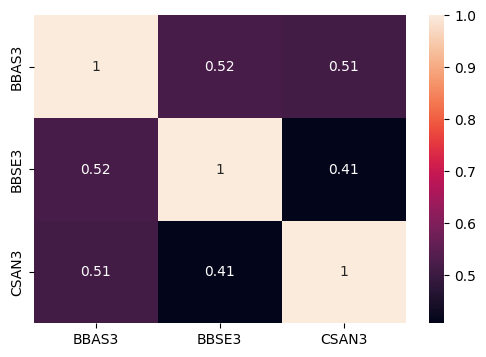

In [51]:
plt.figure(figsize=(6,4))
sns.heatmap(taxa_retorno_lb.corr(), annot=True)

#### Portfolio_TN

In [52]:
taxa_retorno_tn = (df_tn/df_tn.shift(1)) -1 
taxa_retorno_tn.head() 

RAPT3     RANI3     LEVE3
Date                                    
2018-01-02       NaN       NaN       NaN
2018-01-03  0.003342  0.000000  0.009009
2018-01-04  0.038301  0.000000  0.008929
2018-01-05  0.000401 -0.005102 -0.001770
2018-01-08 -0.002004  0.000000 -0.037234

In [53]:
taxa_retorno_tn.std() *100 # DESVIO PADRÃO

RAPT3    2.511847
RANI3    3.949096
LEVE3    2.655522
dtype: float64

In [54]:
taxa_retorno_tn.std() * 246 # DESVIO PADRÂO ANUAL

RAPT3    6.179145
RANI3    9.714777
LEVE3    6.532585
dtype: float64

In [55]:
taxa_retorno_tn.std() *math.sqrt(246) 

RAPT3    0.393968
RANI3    0.619392
LEVE3    0.416502
dtype: float64

<Axes: >

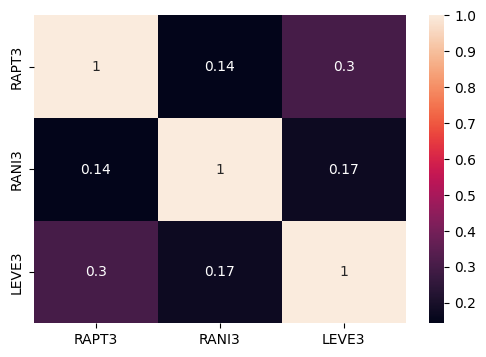

In [56]:
plt.figure(figsize=(6,4))
sns.heatmap(taxa_retorno_tn.corr(), annot=True)

#### Portfolio_BP

In [57]:
taxa_retorno_bp = (df_bp/df_bp.shift(1)) -1 
taxa_retorno_bp.head() 

ITSA3     VIVT3    SAPR11
Date                                    
2018-01-02       NaN       NaN       NaN
2018-01-03 -0.003656 -0.008646 -0.028986
2018-01-04  0.022936 -0.008037  0.010945
2018-01-05  0.000000  0.007585  0.002461
2018-01-08  0.010762 -0.005988  0.010555

In [58]:
taxa_retorno_bp.std() *100 # DESVIO PADRÃO

ITSA3     1.651575
VIVT3     2.006852
SAPR11    1.733438
dtype: float64

In [59]:
taxa_retorno_bp.std() * 246 # DESVIO PADRÂO ANUAL

ITSA3     4.062874
VIVT3     4.936856
SAPR11    4.264256
dtype: float64

In [60]:
taxa_retorno_bp.std() *math.sqrt(246) 

ITSA3     0.259039
VIVT3     0.314762
SAPR11    0.271879
dtype: float64

<Axes: >

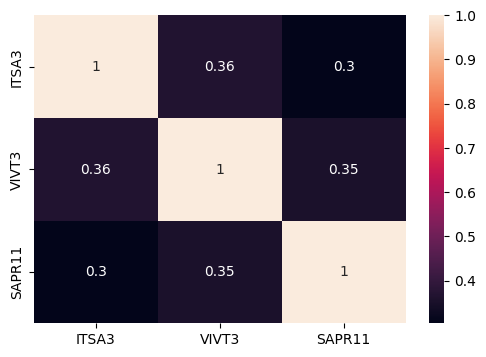

In [61]:
plt.figure(figsize=(6,4))
sns.heatmap(taxa_retorno_bp.corr(), annot=True)

#### Conclusão de Riscos dos Portfólios

* O Portfolio_TN é o mais Arrojado, com media de 0.47 de risco.
* O Portfolio_BP é o mais Conservador, com media de 0.28 de risco.
* O Portfolio_LB acaba sendo Moderado, com media de 0.35 de risco.


## Volatilidade dos Portfólios

#### Portfolio_LB

In [62]:
np.dot(taxa_retorno_lb.cov()* 246, pesos_carteira) 

array([0.09844493, 0.06081444, 0.08943558])

In [63]:
variancia_portfolio_lb = np.dot(pesos_carteira, np.dot(taxa_retorno_lb.cov()* 246, pesos_carteira))
variancia_portfolio_lb

0.08352017947367882

In [64]:
volatilidade_portfolio_lb = math.sqrt(variancia_portfolio_lb)
volatilidade_portfolio_lb 

0.288998580400802

A volatilidade da Carteira sugerida é de 28.89% aprox

#### Portfolio_TN

In [65]:
np.dot(taxa_retorno_tn.cov()* 246, pesos_carteira) 

array([0.08294728, 0.14933396, 0.0874698 ])

In [66]:
variancia_portfolio_tn = np.dot(pesos_carteira, np.dot(taxa_retorno_tn.cov()* 246, pesos_carteira))
variancia_portfolio_tn

0.10563822303499529

In [67]:
volatilidade_portfolio_tn = math.sqrt(variancia_portfolio_tn)
volatilidade_portfolio_tn

0.3250203424941203

A volatilidade da Carteira sugerida é de 32.5% aprox

#### Portfolio_BP

In [68]:
np.dot(taxa_retorno_bp.cov()* 246, pesos_carteira) 

array([0.04048454, 0.05205581, 0.04102191])

In [69]:
variancia_portfolio_bp = np.dot(pesos_carteira, np.dot(taxa_retorno_bp.cov()* 246, pesos_carteira))
variancia_portfolio_bp

0.044359303664913474

In [70]:
volatilidade_portfolio_bp = math.sqrt(variancia_portfolio_bp)
volatilidade_portfolio_bp

0.21061648478909117

A volatilidade da Carteira sugerida é de 21.06% aprox

#### Conclusão da Volatilidade de Portfolios

O Portfolio com mais volatilidade é o Portfolio_TN com 32.5%.<br><br>
Já o Portfolio_LB e Portfolio_BP apresentam 29% e 21%.

## Risco não sistemático dos Portfólios

In [71]:
'''
Risco Não Sistematico do Portfolio_LB
'''
variancia_pesos_lb = (taxa_retorno_lb.var()*246)* pesos_carteira
sub1 = variancia_pesos_lb[0] - variancia_pesos_lb[1] - variancia_pesos_lb[2]
risco_nao_sistematico_lb = (variancia_portfolio_lb - sub1)
risco_nao_sistematico_lb

0.10147395242278515

In [72]:
'''
Risco Não Sistematico do Portfolio_TN
'''
variancia_pesos_tn = (taxa_retorno_tn.var()*246)* pesos_carteira
sub2 = variancia_pesos_tn[0] - variancia_pesos_tn[1] - variancia_pesos_tn[2]
risco_nao_sistematico_tn = (variancia_portfolio_tn - sub2)
risco_nao_sistematico_tn

0.22804083152797472

In [73]:
'''
Risco Não Sistematico do Portfolio_BP
'''
variancia_pesos_bp = (taxa_retorno_bp.var()*246)* pesos_carteira
sub3 = variancia_pesos_bp[0] - variancia_pesos_bp[1] - variancia_pesos_bp[2]
risco_nao_sistematico_bp = (variancia_portfolio_bp - sub3)
risco_nao_sistematico_bp

0.07556076405437034

#### Conclusão do Risco Não Sistemático

Seguindo o comportamento das Volatilidades, <br>
o Risco Não Sistemático do Portfolio_TN sai na frente com 0.22, <br>
sendo quase 50% superior ao Portfolio_LB que é o mais próximo com 0.10<br>


## Alocação e Otimização de Carteiras

1. Definiremos os pesos (cuánto será o investimento em cada ação).
2. Cálculo Sharpe Ratio (medir o desempenho de uma portfólio de ações).
3. Cãlculo de Markowitz (medir o desempenho de uma portfólio de ações).
4. Alocação randômica de pesos (tentando obter o maior valor de Sharp Ratio).
5. Algoritmos de otimização:
* Hill Climb (subida da encosta).
* Simulated Annealing (têmpera simulada).

### 1. Definiremos os pesos aleatóriamente 
(cuánto será o investimento em cada ação?).

#### Portfolio_LB

In [74]:
dataset,datas, acoes_pesos, soma_valor = alocacao_ativos(df_lb, 5000, 4) 

[0.38884224 0.22004183 0.39111592] 1.0


In [75]:
dataset.tail(2)

BBAS3        BBSE3        CSAN3   soma_valor  taxa_retorno
Date                                                                        
2023-09-28  2812.700292  1215.213591  3105.028366  7132.942249      1.499656
2023-09-29  2785.541611  1196.429469  3150.987935  7132.959015      0.000235

In [76]:
acoes_pesos

Ações      Pesos
0  BBAS3  38.884224
1  BBSE3  22.004183
2  CSAN3  39.111592

In [77]:
soma_valor

7132.959014592156

#### Portfolio_TN

In [78]:
dataset_tn,datas_tn, acoes_pesos_tn, soma_valor_tn = alocacao_ativos(df_tn, 5000, 1) 

[3.66625362e-01 6.33274085e-01 1.00552749e-04] 0.9999999999999999


In [79]:
dataset_tn.tail(2)

RAPT3         RANI3     LEVE3    soma_valor  taxa_retorno
Date                                                                       
2023-09-28  3725.213876  20532.942568  0.840657  24258.997101      2.759006
2023-09-29  3694.585075  20468.322826  0.844281  24163.752182     -0.392617

In [80]:
acoes_pesos_tn

Ações      Pesos
0  RAPT3  36.662536
1  RANI3  63.327408
2  LEVE3   0.010055

In [81]:
soma_valor_tn

24163.75218188539

#### Portfolio_BP

In [82]:
dataset_bp,datas_bp, acoes_pesos_bp, soma_valor_bp = alocacao_ativos(df_bp, 5000, 19) 

[0.08820812 0.68846437 0.2233275 ] 0.9999999999999999


In [83]:
dataset_bp.tail(2)

ITSA3        VIVT3       SAPR11   soma_valor  taxa_retorno
Date                                                                       
2023-09-28  469.681432  3944.169107  1168.693319  5582.543858     -0.066111
2023-09-29  473.824153  4001.939878  1164.647490  5640.411521      1.036582

In [84]:
acoes_pesos_bp

Ações      Pesos
0   ITSA3   8.820812
1   VIVT3  68.846437
2  SAPR11  22.332750

In [85]:
soma_valor_bp

5640.411520764283

### Visualização do Portfólio

In [86]:
figura = px.line(x=datas['Data'], y=dataset['taxa_retorno'], title='Retorno diário do Portfólio_LB')
figura.show()

In [87]:
figura = px.line(x=datas_tn['Data'], y=dataset_tn['taxa_retorno'], title='Retorno diário do Portfólio_TN')
figura.show()

In [88]:
figura = px.line(x=datas_bp['Data'], y=dataset_bp['taxa_retorno'], title='Retorno diário do Portfólio_BP')
figura.show()

In [89]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=datas['Data'], y=dataset['soma_valor'], name='Portfolio_LB'))
fig.add_trace(go.Scatter(x=datas_tn['Data'], y=dataset_tn['soma_valor'], name='Portfolio_TN'))
fig.add_trace(go.Scatter(x=datas_bp['Data'], y=dataset_bp['soma_valor'], name='Portfolio_BP'))

fig.update_layout(title_text='Evolução do Patrimônio dos Portfólios', height=600, width=800)

fig.show()


Devemos lembrar que a asignação dos pesos é aleatório!

## Métrica: Sharpe Ratio
Essa métrica calcula o retorno do investimento comparado com o risco.

S = (Rp - Rf)/SIGMAp

* Rp: retorno esperado do portfólio 
* Rf: retorno sem riscos(risk-free)
* SIGMA p: desvio padrão do portfólio

#### Portfolio_LB

Taxa de Retorno Acumulado em todo o período

In [90]:
(dataset['soma_valor'].tail(1).iloc[0] / dataset['soma_valor'].iloc[0] )- 1 # -1 pela formula da taxa de retorno simples

0.42659180291843124

In [91]:
'''
Desvio Padrão
'''
dataset['taxa_retorno'].std()

1.9693584510311304

In [92]:
'''
Sharpe Ratio
'''
(dataset['taxa_retorno'].mean() / dataset['taxa_retorno'].std() ) * np.sqrt(246) # Calculo anual

0.35357900136106385

#### Portfolio_TN

In [93]:
(dataset_tn['soma_valor'].tail(1).iloc[0] / dataset_tn['soma_valor'].iloc[0] )- 1 

3.8327504363770775

In [94]:
'''
Desvio Padrão
'''
dataset_tn['taxa_retorno'].std()

3.2039957368397154

In [95]:
'''
Sharpe Ratio
'''
(dataset_tn['taxa_retorno'].mean() / dataset_tn['taxa_retorno'].std() ) * np.sqrt(246) # Calculo anual

0.7829785427457737

#### Portfolio_BP

In [96]:
(dataset_bp['soma_valor'].tail(1).iloc[0] / dataset_bp['soma_valor'].iloc[0] )- 1 

0.1280823041528567

In [97]:
'''
Desvio Padrão
'''
dataset_bp['taxa_retorno'].std()

6.016964993272281

In [98]:
'''
Sharpe Ratio
'''
(dataset_bp['taxa_retorno'].mean() / dataset_bp['taxa_retorno'].std() ) * np.sqrt(246) # Calculo anual

0.31272987445096306

Temos no Portfolio_TN a  presença do maior sharpe ratio medio anual de 0.78<br><br>
Nota: 
O valor Sharpe Ratio tem as seguintes considerações:
* Maior que 1 consideravel
* Maior que 2 bom
* Maior que 3 muito bom

### Simulação com Renda Fixa
O que aconteceria se eu investia os 5000 em renda fixa?

In [99]:
dinheiro_total = 5000

In [100]:
taxa_selic_2018 = 6.50
taxa_selic_2019 = 5.0
taxa_selic_2020 = 2.0
taxa_selic_2021 = 4.2
taxa_selic_2022 = 10.04
taxa_selic_2023 = 13.75

#### Portfolio_LB

In [101]:
soma_valor - dinheiro_total

2132.9590145921557

In [102]:
valor_2018 = dinheiro_total + (dinheiro_total * taxa_selic_2018 / 100)
valor_2018

5325.0

In [103]:
valor_2019 = valor_2018 + (valor_2018 * taxa_selic_2019 / 100)
valor_2019

5591.25

In [104]:
valor_2020 = valor_2019 + (valor_2019 * taxa_selic_2020 / 100)
valor_2020

5703.075

In [105]:
valor_2021 = valor_2020 + (valor_2020 * taxa_selic_2021 / 100)
valor_2021

5942.60415

In [106]:
valor_2022 = valor_2021 + (valor_2021 * taxa_selic_2022 / 100)
valor_2022

6539.24160666

In [107]:
valor_2023 = valor_2022 + (valor_2022 * taxa_selic_2023 / 100)
valor_2023

7438.38732757575

In [108]:
rendimentos = valor_2023 - dinheiro_total
rendimentos 

2438.3873275757496

In [109]:
ir = rendimentos * 15 / 100
ir 

365.75809913636243

In [110]:
valor_2023 - ir

7072.629228439388

In [111]:
taxa_selic_historico = np.array([6.50, 5.0, 2.0, 4.2, 10.04, 13.75])
taxa_selic_historico.mean() / 100 

0.06914999999999999

In [112]:
(dataset['taxa_retorno'].mean() - taxa_selic_historico.mean() / 100) / dataset['taxa_retorno'].std() * np.sqrt(246)

-0.19714622098586063

 isso significa que, a taxa de retorno do ativo financeiro é 0.19 desvios padrão abaixo da média da taxa Selic histórica, após a normalização. Esse valor negativo indica que, em média, o ativo financeiro teve um desempenho inferior em relação à taxa Selic histórica, considerando a volatilidade (desvio padrão) dos retornos.<br>

#### Portfolio_TN

In [113]:
(dataset_tn['taxa_retorno'].mean() - taxa_selic_historico.mean() / 100) / dataset_tn['taxa_retorno'].std() * np.sqrt(246)

0.44447142229164577

Concluímos que o ativo superou a média da taxa Selic histórica. 

#### Portfolio_BP

In [114]:
(dataset_bp['taxa_retorno'].mean() - taxa_selic_historico.mean() / 100) / dataset_bp['taxa_retorno'].std() * np.sqrt(246)

0.13247697751079388

Concluímos que o ativo superou a média da taxa Selic histórica em 0.13. 

## Alocação com Markowitz
 Teoria financeira que tem como objetivo, otimizar o equilíbrio entre o retorno esperado e o risco.  Levando em consideração seu apetite pelo risco e suas metas de retorno

In [115]:
import sys
1 - sys.maxsize

-9223372036854775806

#### Portfolio_LB

In [116]:
sharpe_ratio_LB, melhores_pesos_LB, ls_retorno_LB, ls_volatilidade_LB, ls_sharpe_ratio_LB, melhor_volatilidade_LB, melhor_retorno_lb = alocacao_portfolio(df_lb, 5000, taxa_selic_historico.mean() / 100, 1000)

In [117]:
sharpe_ratio_LB, melhores_pesos_LB 

(0.03065334847506114, array([0.04987191, 0.0116479 , 0.93848019]))

In [118]:
_, _, acoes_pesos_LB, soma_valor_LB = alocacao_ativos(df_lb, 5000, melhores_pesos=melhores_pesos_LB)

In [119]:
acoes_pesos_LB, soma_valor_LB 

(   Ações      Pesos
 0  BBAS3   4.987191
 1  BBSE3   1.164790
 2  CSAN3  93.848019,
 7981.374985407755)

Segundo o meu cálculo de Markowitz, a minha melhor distribuição dos pesos seria:
 * BBAS3   7.13
 * BBSE3   0.65
 * CSAN3  92.20
 Considerando um Sharpe Ratio de 0.03 (lembrando que enquanto maior o sharpe ratio, melhor. No nosso caso, temos um sharp ratio timido<br><br>
 Além de obter um rendimento de 7981.37 reais (melhor resultado obtido até o momento).

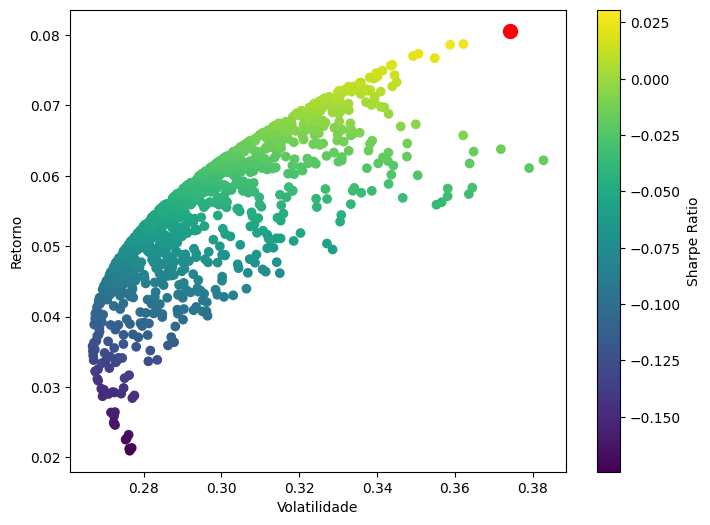

In [120]:
plt.figure(figsize=(8,6))
plt.scatter(ls_volatilidade_LB, ls_retorno_LB, c=ls_sharpe_ratio_LB)
plt.colorbar(label='Sharpe Ratio') 
plt.xlabel('Volatilidade') 
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade_LB, melhor_retorno_lb, c='red', s=100);

#### Portfolio_tn

In [121]:
sharpe_ratio_tn, melhores_pesos_tn, ls_retorno_tn, ls_volatilidade_tn, ls_sharpe_ratio_tn, melhor_volatilidade_tn, melhor_retorno_tn = alocacao_portfolio(df_tn, 5000, taxa_selic_historico.mean() / 100, 1000)

In [122]:
sharpe_ratio_tn, melhores_pesos_tn 

(0.48273698016217936, array([0.31270507, 0.57641148, 0.11088345]))

In [123]:
_, _, acoes_pesos_tn, soma_valor_tn = alocacao_ativos(df_tn, 5000, melhores_pesos=melhores_pesos_tn) 
acoes_pesos_tn, soma_valor_tn 

(   Ações      Pesos
 0  RAPT3  31.270507
 1  RANI3  57.641148
 2  LEVE3  11.088345,
 22712.67889899023)

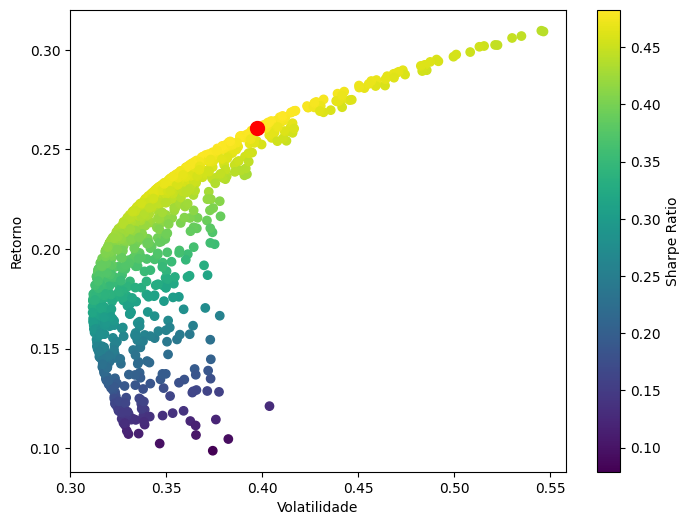

In [124]:
plt.figure(figsize=(8,6))
plt.scatter(ls_volatilidade_tn, ls_retorno_tn, c=ls_sharpe_ratio_tn)
plt.colorbar(label='Sharpe Ratio') 
plt.xlabel('Volatilidade') 
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade_tn, melhor_retorno_tn, c='red', s=100);

#### Portfolio_BP

In [125]:
sharpe_ratio_bp, melhores_pesos_bp, ls_retorno_bp, ls_volatilidade_bp, ls_sharpe_ratio_bp, melhor_volatilidade_bp, melhor_retorno_bp = alocacao_portfolio(df_bp, 5000, taxa_selic_historico.mean() / 100, 1000)

In [126]:
sharpe_ratio_bp, melhores_pesos_bp 

(-0.13852872449332676, array([1.12225708e-02, 9.88593668e-01, 1.83761473e-04]))

In [127]:
_, _, acoes_pesos_bp, soma_valor_bp = alocacao_ativos(df_bp, 5000, melhores_pesos=melhores_pesos_bp) 
acoes_pesos_bp, soma_valor_bp  

(    Ações      Pesos
 0   ITSA3   1.122257
 1   VIVT3  98.859367
 2  SAPR11   0.018376,
 5807.788489698413)

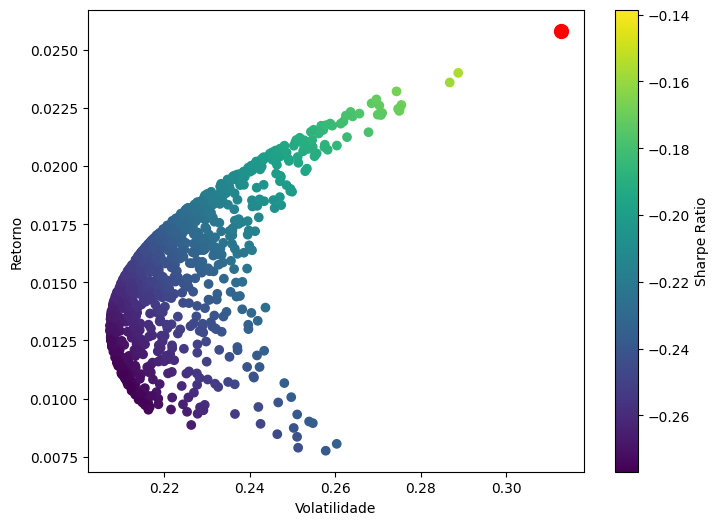

In [128]:
plt.figure(figsize=(8,6))
plt.scatter(ls_volatilidade_bp, ls_retorno_bp, c=ls_sharpe_ratio_bp)
plt.colorbar(label='Sharpe Ratio') 
plt.xlabel('Volatilidade') 
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade_bp, melhor_retorno_bp, c='red', s=100);

## Algoritmos de Otimização
MLRose (Machine Learning, Randomized Optimization, and Search Library)  é utilizado quando desejamos maximizar ou minimizar o valor da métrica Sharpe Ratio. 


<br>Nesta oportunidade usaremos os seguintes algoritmos de otimização:
* Hill Climb
* Simulation Anneling
* Algoritmos genéticos 

In [129]:
import mlrose_hiive

In [130]:
taxa_selic_historico

array([ 6.5 ,  5.  ,  2.  ,  4.2 , 10.04, 13.75])

In [213]:
sem_risco = taxa_selic_historico.mean() / 100
dataset_original_lb = df_lb.copy()
dataset_original_tn = df_tn.copy() 
dataset_original_bp = df_bp.copy()
dinheiro_total = 5000

### Método: Hill Climb 

#### Portfolio_LB

In [214]:
def fitness_function_lb(solucao):
  dataset = dataset_original_lb.copy()
  pesos = solucao / solucao.sum()

  for i in dataset.columns:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  dataset['soma valor'] = dataset.sum(axis = 1)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

  sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [221]:
np.random.seed(2)
pesos_lb = np.random.random(len(dataset_original_lb.columns) )
pesos_lb = pesos_lb / pesos_lb.sum()
pesos_lb

array([0.43100234, 0.02562935, 0.54336831])

In [222]:
fitness_function_lb(pesos_lb)

-0.1201501233341442

In [223]:
def visualiza_alocacao_lb(solucao):
  colunas = dataset_original_lb.columns
  for i in range(len(solucao)):
    print(colunas[i], solucao[i] * 100)

In [224]:
visualiza_alocacao_lb(pesos_lb)

BBAS3 43.10023383487313
BBSE3 2.5629351369693314
CSAN3 54.33683102815755


In [226]:
#fitness = mlrose.CustomFitness(fitness_function)
fitness_lb = mlrose_hiive.CustomFitness(fitness_function_lb) 

problema_maximizacao = mlrose_hiive.ContinuousOpt(length=3, fitness_fn=fitness_lb,
                                            maximize = True, min_val = 0, max_val = 1)

problema_minimizacao = mlrose_hiive.ContinuousOpt(length=3, fitness_fn=fitness_lb,
                                            maximize = False, min_val = 0, max_val = 1)

In [227]:
resultado_lb = mlrose_hiive.hill_climb(problema_maximizacao, random_state=1)
melhor_solucao_lb = resultado_lb[0]  
melhor_custo_lb = resultado_lb[1]  

In [228]:
melhor_solucao_lb, melhor_custo_lb 

(array([0.717022, 0.      , 0.      ]), -0.07981946643470945)

In [229]:
melhor_solucao_lb = melhor_solucao_lb / melhor_solucao_lb.sum()   
melhor_solucao_lb, melhor_solucao_lb.sum()   

(array([1., 0., 0.]), 1.0)

In [231]:
visualiza_alocacao_lb(melhor_solucao_lb)  
_, _, _, soma_valor_lb = alocacao_ativos(df_lb, 5000, melhores_pesos=melhor_solucao_lb) 
soma_valor_lb  

BBAS3 100.0
BBSE3 0.0
CSAN3 0.0


7163.6805144153395

#### Portfolio_TN

In [232]:
def fitness_function_tn(solucao):
  dataset = dataset_original_tn.copy()
  pesos = solucao / solucao.sum()

  for i in dataset.columns:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  dataset['soma valor'] = dataset.sum(axis = 1)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

  sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [233]:
np.random.seed(2)
pesos_tn = np.random.random(len(dataset_original_tn.columns) )
pesos_tn = pesos_tn / pesos_tn.sum()
pesos_tn

array([0.43100234, 0.02562935, 0.54336831])

In [234]:
fitness_function_tn(pesos_tn)

-0.001697524222650992

In [235]:
def visualiza_alocacao_tn(solucao):
  colunas = dataset_original_tn.columns
  for i in range(len(solucao)):
    print(colunas[i], solucao[i] * 100)

In [236]:
visualiza_alocacao_tn(pesos_tn)

RAPT3 43.10023383487313
RANI3 2.5629351369693314
LEVE3 54.33683102815755


In [240]:
#fitness = mlrose.CustomFitness(fitness_function)
fitness_tn = mlrose_hiive.CustomFitness(fitness_function_tn) 

problema_maximizacao_tn = mlrose_hiive.ContinuousOpt(length=3, fitness_fn=fitness_tn,
                                            maximize = True, min_val = 0, max_val = 1)

problema_minimizacao_tn = mlrose_hiive.ContinuousOpt(length=3, fitness_fn=fitness_tn,
                                            maximize = False, min_val = 0, max_val = 1)

In [241]:
resultado_tn = mlrose_hiive.hill_climb(problema_maximizacao_tn, random_state=1)
melhor_solucao_tn = resultado_tn[0]  
melhor_custo_tn = resultado_tn[1]  

In [242]:
melhor_solucao_tn, melhor_custo_tn 

(array([0.        , 0.72032449, 0.        ]), 0.5368284366179564)

In [243]:
melhor_solucao_tn = melhor_solucao_tn / melhor_solucao_tn.sum()   
melhor_solucao_tn, melhor_solucao_tn.sum()   

(array([0., 1., 0.]), 1.0)

In [244]:
visualiza_alocacao_tn(melhor_solucao_tn)  
_, _, _, soma_valor_tn = alocacao_ativos(df_tn, 5000, melhores_pesos=melhor_solucao_tn) 
soma_valor_tn  

RAPT3 0.0
RANI3 100.0
LEVE3 0.0


32321.428136992392

#### Portfolio_BP

In [245]:
def fitness_function_bp(solucao):
  dataset = dataset_original_bp.copy()
  pesos = solucao / solucao.sum()

  for i in dataset.columns:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  dataset['soma valor'] = dataset.sum(axis = 1)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

  sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)

  return sharpe_ratio

In [246]:
np.random.seed(2)
pesos_bp = np.random.random(len(dataset_original_bp.columns) )
pesos_bp = pesos_bp / pesos_bp.sum()
pesos_bp

array([0.43100234, 0.02562935, 0.54336831])

In [247]:
fitness_function_bp(pesos_bp)

-0.6357388447338747

In [248]:
def visualiza_alocacao_bp(solucao):
  colunas = dataset_original_bp.columns
  for i in range(len(solucao)):
    print(colunas[i], solucao[i] * 100)

In [249]:
visualiza_alocacao_bp(pesos_bp)

ITSA3 43.10023383487313
VIVT3 2.5629351369693314
SAPR11 54.33683102815755


In [250]:
#fitness = mlrose.CustomFitness(fitness_function)
fitness_bp = mlrose_hiive.CustomFitness(fitness_function_bp) 

problema_maximizacao_bp = mlrose_hiive.ContinuousOpt(length=3, fitness_fn=fitness_bp,
                                            maximize = True, min_val = 0, max_val = 1)

problema_minimizacao_bp = mlrose_hiive.ContinuousOpt(length=3, fitness_fn=fitness_bp,
                                            maximize = False, min_val = 0, max_val = 1)

In [251]:
resultado_bp = mlrose_hiive.hill_climb(problema_maximizacao_bp, random_state=1)
melhor_solucao_bp = resultado_bp[0]  
melhor_custo_bp = resultado_bp[1]  

In [252]:
melhor_solucao_bp, melhor_custo_bp 

(array([0.00000000e+00, 7.20324493e-01, 1.14374817e-04]), 0.4150900181212002)

In [253]:
melhor_solucao_bp = melhor_solucao_bp / melhor_solucao_bp.sum()   
melhor_solucao_bp, melhor_solucao_bp.sum()   

(array([0.00000000e+00, 9.99841243e-01, 1.58757144e-04]), 1.0)

In [254]:
visualiza_alocacao_bp(melhor_solucao_bp)  
_, _, _, soma_valor_bp = alocacao_ativos(df_bp, 5000, melhores_pesos=melhor_solucao_bp) 
soma_valor_bp  

ITSA3 0.0
VIVT3 99.98412428557315
SAPR11 0.015875714426846925


5812.754708577872

No pior dos casos, estariamos ganhando 5347.17 reais.

### Simulated Annealing
O Algoritmo irá procurando o maior Sharpe Ratio possível, mas se ao mudar de pesos ele piorar o SHarpe Ratio, então acabará ficando com a combinação que oferece o melhor resultado de sharpe ratio. 

#### Portfolio_LB

In [271]:
resul_lb = mlrose_hiive.simulated_annealing(problema_maximizacao, random_state = 2)
melhor_soluca_lb =resul_lb[0]
melhor_custo_lb=resul_lb[1]
melhor_soluca_lb = melhor_soluca_lb / melhor_soluca_lb.sum()
melhor_soluca_lb, melhor_custo_lb

(array([0., 1., 0.]), 0.5368284366179564)

In [272]:
visualiza_alocacao_lb(melhor_soluca_lb)

BBAS3 0.0
BBSE3 100.0
CSAN3 0.0


In [273]:
_, _, _, soma_valo_lb = alocacao_ativos(df_lb, 5000, melhores_pesos=melhor_soluca_lb)
soma_valo_lb 

5437.281925924961

#### Portfolio_TN

In [274]:
resul_tn = mlrose_hiive.simulated_annealing(problema_maximizacao_tn, random_state = 1)
melhor_soluca_tn =resul_tn[0]
melhor_custo_tn=resul_tn[1]
melhor_soluca_tn = melhor_soluca_tn / melhor_soluca_tn.sum()
melhor_soluca_tn, melhor_custo_tn

(array([0., 1., 0.]), 0.5368284366179564)

In [275]:
visualiza_alocacao_tn(melhor_soluca_tn)

RAPT3 0.0
RANI3 100.0
LEVE3 0.0


In [276]:
_, _, _, soma_valo_tn = alocacao_ativos(df_tn, 5000, melhores_pesos=melhor_soluca_tn)
soma_valo_tn 

32321.428136992392

#### Portfolio_BP

In [277]:
resul_bp = mlrose_hiive.simulated_annealing(problema_maximizacao_bp, random_state = 1)
melhor_soluca_bp =resul_bp[0]
melhor_custo_bp=resul_bp[1]
melhor_soluca_bp = melhor_soluca_bp / melhor_soluca_bp.sum()
melhor_soluca_bp, melhor_custo_bp

(array([0.        , 0.90909091, 0.09090909]), 0.34698441151224646)

In [278]:
visualiza_alocacao_bp(melhor_soluca_bp)

ITSA3 0.0
VIVT3 90.9090909090909
SAPR11 9.090909090909092


In [280]:
_, _, _, soma_valo_bp = alocacao_ativos(df_bp, 5000, melhores_pesos=melhor_soluca_bp)
soma_valo_bp 

5758.497449402186